### Import Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
from models.resnet import ResNet18
from utils.data import train_dataset, test_dataset
from utils.training import train, test

from utils.config import config
from utils.common import (
    find_lr,
    one_cycle_lr,
    show_model_summary,
    show_img_grid,
    show_random_images,
    lossacc_plots,
    lr_plots,
    get_misclassified,
    plot_misclassified,
)
from utils.gradcam import generate_gradcam, visualize_gradcam

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Shubham\anaconda3\envs\myenv\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create Dataloaders

In [3]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=config.data.batch_size,
    shuffle=config.data.shuffle,
    num_workers=config.data.num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=config.data.batch_size,
    shuffle=config.data.shuffle,
    num_workers=config.data.num_workers,
)

### Check Sample Images

In [4]:
images, labels = next(iter(trainloader))

In [5]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(4))

In [6]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


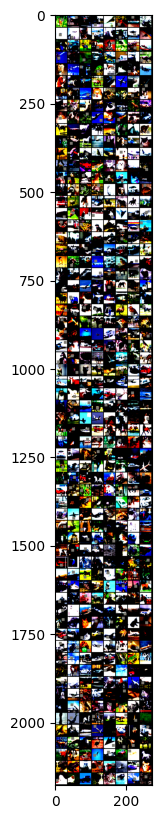

In [7]:
show_random_images(data_loader=trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


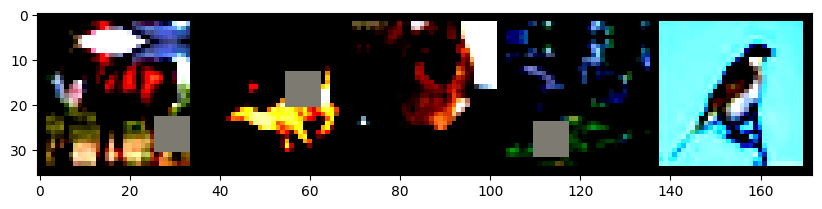

In [8]:
show_img_grid(images[25:30])

### Set Device

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
device

'cuda'

### Generate Model Summary

In [11]:
model = ResNet18().to(device)

In [12]:
show_model_summary(model, config.data.batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ResNet                                   [512, 3, 32, 32]          [512, 10]                 --                        --
├─Conv2d: 1-1                            [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
├─BatchNorm2d: 1-2                       [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
├─Sequential: 1-3                        [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
│    └─BasicBlock: 2-1                   [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
│    │    └─Conv2d: 3-1                  [512, 64, 32, 32]         [512, 64, 32, 32]         36,864                    [3, 3]
│    │    └─BatchNorm2d: 3-2             [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    │

### Declare Optimizer & Criterion

In [13]:
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=config.training.lr,
    weight_decay=config.training.weight_decay,
)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/600 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-03


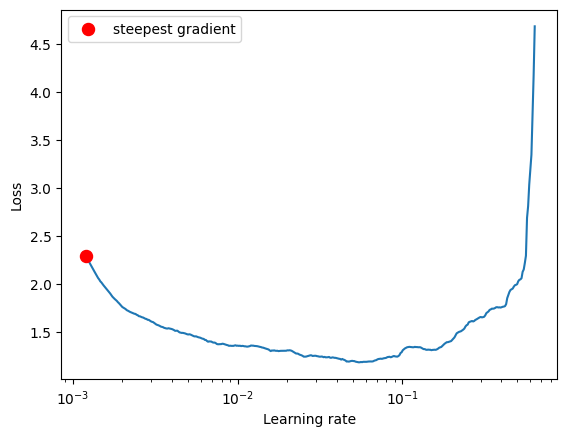

In [14]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=config.training.lrfinder.numiter,
    endlr=config.training.lrfinder.endlr,
    startlr=1e-3,  # config.training.lrfinder.startlr,
)

### Create the Scheduler - One Cycle Policy

In [14]:
epochs = config.training.epochs
maxlr = 1.20E-03
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [15]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[], lr=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc, lrs = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
        scheduler=scheduler,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    results["lr"].extend(lrs)
    results["epoch"].append(epoch)

Epoch: 1


Loss=1.30 Accuracy=39.10: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.04it/s]



Test set: Average loss: 1.7088, Accuracy: 4455/10000 (44.55%)

Epoch: 2


Loss=1.06 Accuracy=58.45: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.04it/s]



Test set: Average loss: 1.2554, Accuracy: 5696/10000 (56.96%)

Epoch: 3


Loss=0.90 Accuracy=68.14: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.8843, Accuracy: 6954/10000 (69.54%)

Epoch: 4


Loss=0.67 Accuracy=73.92: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.7906, Accuracy: 7393/10000 (73.93%)

Epoch: 5


Loss=0.66 Accuracy=77.30: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 1.3522, Accuracy: 6358/10000 (63.58%)

Epoch: 6


Loss=0.62 Accuracy=80.25: 100%|████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]



Test set: Average loss: 0.6603, Accuracy: 7823/10000 (78.23%)

Epoch: 7


Loss=0.50 Accuracy=83.16: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.5536, Accuracy: 8129/10000 (81.29%)

Epoch: 8


Loss=0.35 Accuracy=85.12: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.7206, Accuracy: 7747/10000 (77.47%)

Epoch: 9


Loss=0.44 Accuracy=87.05: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.4400, Accuracy: 8523/10000 (85.23%)

Epoch: 10


Loss=0.34 Accuracy=88.30: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.5622, Accuracy: 8223/10000 (82.23%)

Epoch: 11


Loss=0.33 Accuracy=89.56: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.4772, Accuracy: 8483/10000 (84.83%)

Epoch: 12


Loss=0.35 Accuracy=90.73: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.4394, Accuracy: 8584/10000 (85.84%)

Epoch: 13


Loss=0.25 Accuracy=91.74: 100%|████████████████████████████████████████████████████████| 98/98 [00:45<00:00,  2.17it/s]



Test set: Average loss: 0.4374, Accuracy: 8651/10000 (86.51%)

Epoch: 14


Loss=0.21 Accuracy=93.01: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.3988, Accuracy: 8710/10000 (87.10%)

Epoch: 15


Loss=0.25 Accuracy=93.74: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.4676, Accuracy: 8620/10000 (86.20%)

Epoch: 16


Loss=0.23 Accuracy=94.86: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.3433, Accuracy: 8914/10000 (89.14%)

Epoch: 17


Loss=0.10 Accuracy=95.81: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.3449, Accuracy: 8979/10000 (89.79%)

Epoch: 18


Loss=0.15 Accuracy=96.67: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.3294, Accuracy: 9006/10000 (90.06%)

Epoch: 19


Loss=0.08 Accuracy=97.65: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.3091, Accuracy: 9130/10000 (91.30%)

Epoch: 20


Loss=0.06 Accuracy=98.14: 100%|████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.3011, Accuracy: 9157/10000 (91.57%)



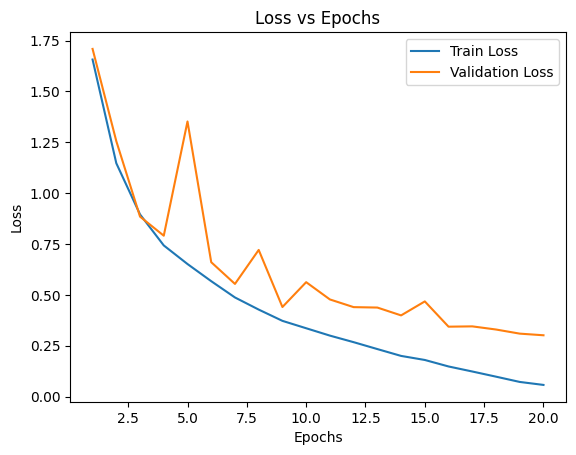

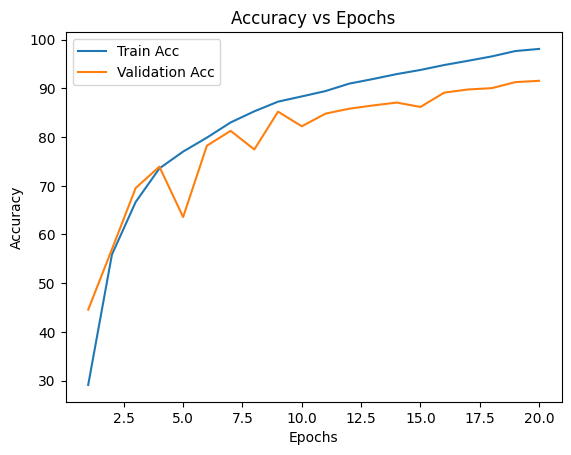

In [16]:
lossacc_plots(results)

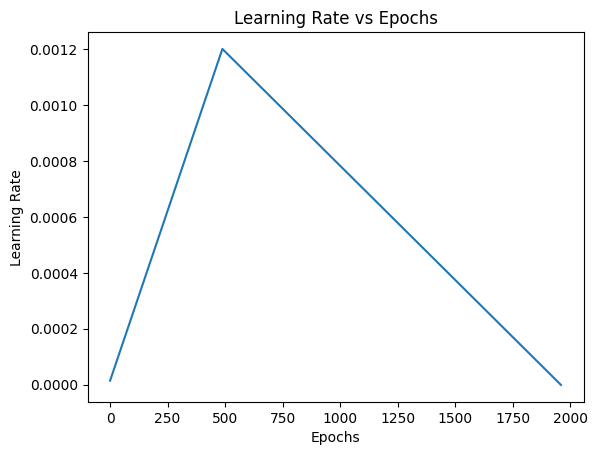

In [17]:
lr_plots(results, length=len(trainloader) * epochs)

### Misclassified Images

In [18]:
misimgs, mistgts, mispreds = get_misclassified(model, testloader, device, mis_count=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

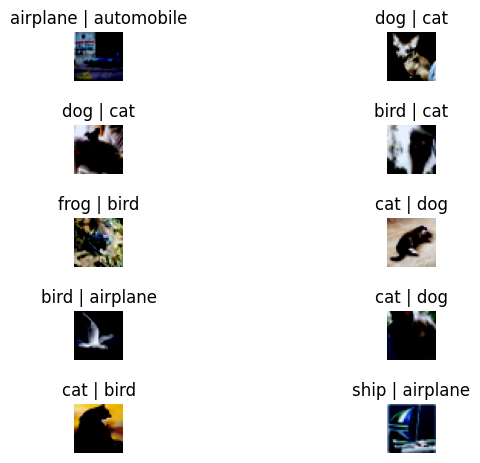

In [19]:
plot_misclassified(misimgs, mistgts, mispreds, train_dataset.classes)
# Actual | Predicted

In [20]:
target_layers = [model.layer3[-1]]  # 8x8
rgb_imgs = [(img / img.max()).permute(1, 2, 0).cpu().numpy() for img in misimgs]
cam_images = generate_gradcam(
    model=model,
    target_layers=target_layers,
    images=misimgs,
    labels=mistgts,
    rgb_imgs=rgb_imgs,
)

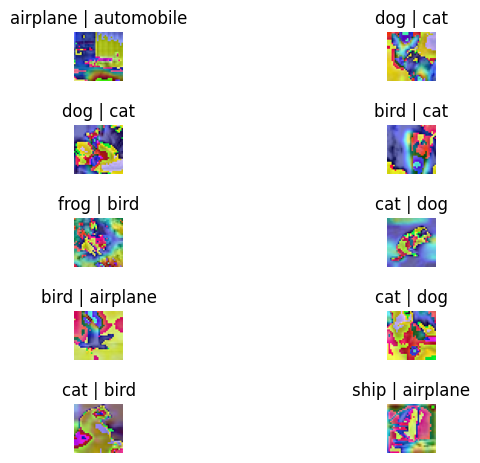

In [21]:
visualize_gradcam(cam_images, mistgts, mispreds, train_dataset.classes)
# Actual | Predicted